# Imports

In [1]:
from importlib import reload
import imports.tkinterImports
reload(imports.tkinterImports)
from imports.tkinterImports import *

import imports.otherImports
reload(imports.otherImports)
from imports.otherImports import *

import imports.dataProcessingImports
reload(imports.dataProcessingImports)
from imports.dataProcessingImports import *

import imports.modelImports
reload(imports.modelImports)
from imports.modelImports import *

import imports.torchImports
reload(imports.torchImports)
from imports.torchImports import *

import imports.metricsImports
reload(imports.metricsImports)
from imports.metricsImports import *


## Import data

In [9]:
data_path = r'Data\train.csv'
temp_data = pd.read_csv(data_path, index_col=['Id'])

train_data = pd.DataFrame(temp_data)


In [133]:
class ModelHolder():
    def __init__(self):
        self.lin_reg = torch.load("models/linear_regression.pt")
        self.log_reg_for_human = torch.load("models/logistic_regression.pt")
        self.gaussian_bayes_model = torch.load("models/gaussian_naive_bayes.pt")
        self.multinomial_bayes_model = torch.load("models/multinomial_naive_bayes.pt")
        self.rfc_bagging_model = torch.load("models/randomForestClassifier_with_bagging.pt")
        self.decisionTree_boosting_model = torch.load("models/decisionTreeClassifier_with_boosting.pt")
        self.stacking_model = torch.load("models/stackingClassifier.pt")
        self.nn_model = torch.load("models/neural_network_for_human.pt")
        
    

# Uge 10 kapitel 7

In [14]:

# Linear model data configuration
lin_X = train_data.drop(columns=['Pawpularity'])
lin_y = train_data['Pawpularity']
random = 30997
X_train, X_test, y_train, y_test = train_test_split(lin_X,lin_y,test_size=0.2,random_state=random)

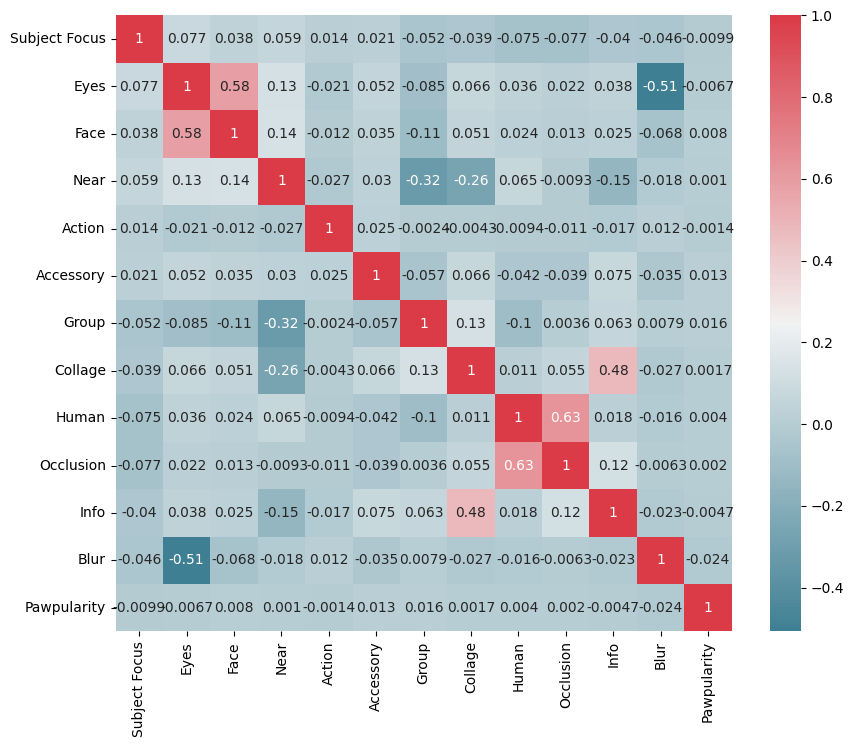

In [105]:
def correlationMatrix(data):
    f, ax = plt.subplots(figsize=(10, 8))
    corr = data.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool_),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
    plt.savefig("static/correlationmatrix.png")
correlationMatrix(train_data)


In [106]:

def linear_regression( X: pd.DataFrame, y: pd.DataFrame):
    lin_reg = LinearRegression()
    lin_reg.fit(X,y)
    return lin_reg

lin_reg = linear_regression(X_train,y_train)
torch.save(lin_reg, "models/linear_regression.pt")


In [18]:
# Configure data for logistic regression
columns =   ["Occlusion", "Near", "Subject Focus", "Group"]
logiX = train_data[columns]
logiy = train_data['Human'].values
logiX_train, logiX_test,logiy_train,logiy_test = train_test_split(logiX,logiy,test_size=0.2,random_state=random)


In [ ]:

def logistic_regression_contains_human(X: pd.DataFrame, y:pd.DataFrame):
    log_reg = LogisticRegression()
    log_reg.fit(X,y)
    return log_reg

logi_reg = logistic_regression_contains_human(logiX_train,logiy_train)
torch.save(logi_reg, "models/logistic_regression.pt")


# Uge 10 kapitel 8

## ROC Curve
*For binary classifier*

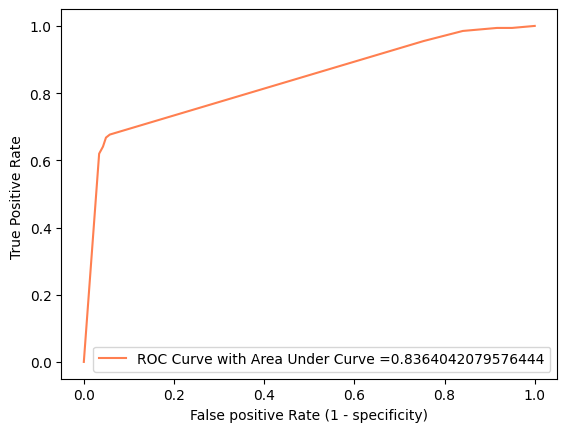

In [108]:
def get_roccurve(model, X_test_data: npt.ArrayLike, y_test_data: npt.ArrayLike, reg_type_name: str = ""):
    y_pred_proba = model.predict_proba(X=X_test_data)[:,1]
    [fpr, tpr, thr] = roc_curve(y_test_data, y_pred_proba)
    auc (fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='coral', label = 'ROC Curve with Area Under Curve ='+str(auc (fpr, tpr)))
    plt.xlabel('False positive Rate (1 - specificity)')
    plt.ylabel('True Positive Rate ')
    plt.legend(loc='lower right')
    plt.savefig("./static/roccurve_" + reg_type_name + ".png")

get_roccurve(logi_reg, logiX_test, logiy_test, "logisticregression")

## Confusion matrix
*For classifiers*

In [109]:
def get_confusionmatrix(model, X_test_data: npt.ArrayLike, y_test_data: npt.ArrayLike):
    logiy_pred = model.predict(X_test_data)
    conf_matrix = confusion_matrix(y_test_data, logiy_pred)
    return conf_matrix

get_confusionmatrix(logi_reg, logiX_test, logiy_test)

array([[1579,   70],
       [ 120,  214]], dtype=int64)

## Performance metrics
*For classifiers*

In [12]:
def get_performancemetrics(model, X_test_data: npt.ArrayLike, y_test_data: npt.ArrayLike, model_type_name: str = ""):
    y_pred = model.predict(X_test_data)
    p = precision_score(y_test_data, y_pred, average='micro')
    r = recall_score(y_test_data, y_pred, average='micro')
    f = f1_score(y_test_data, y_pred, average='micro')
    a = accuracy_score(y_test_data,y_pred)
    return "Here're the metrics for the trained model(" + model_type_name + "):\nPrecision:\t{}\nRecall:\t\t{}\nF-Score:\t\t{}\nAccuracy:\t{}".format(p,r,f,a)

# get_performancemetrics(logi_reg, logiX_test, logiy_test, "logisticregression")

## Cross validation for linear regression

In [15]:
def do_crossvalidation():
    kf = KFold(n_splits=5)
    kf.get_n_splits(lin_X)

    score_history = []
    for train, test in kf.split(lin_X, lin_y):
        reg = LinearRegression()
        reg.fit(lin_X.values[train,:], lin_y.iloc[train])
        y_pred = reg.predict(lin_X.values[test,:])
        score_history.append(reg.score(lin_X.values[test,:], lin_y.iloc[test]))
    return '\n'.join(map(str, score_history))


do_crossvalidation()

'-0.0011381531784111498\n-0.0032655098200438104\n0.0031372020899773645\n-0.0007086870944514878\n-0.0024666721129855684'

## Uge 11 kapitel 9

In [138]:
#Configure data for bayes and ensemble (No occlusion)
bayesX = train_data.drop(columns=['Occlusion', 'Pawpularity'])
bayesy = train_data['Occlusion']
bayesX_train, bayesX_test,bayesy_train,bayesy_test = train_test_split(bayesX,bayesy,test_size=0.2,random_state=random)

def train_gaussian_bayes(X, y):
    GNB = GaussianNB()
    GNB.fit(X, y)
    return GNB
    
def train_multinomial_bayes(X, y):
    MNB = MultinomialNB()
    MNB.fit(X, y)
    return MNB
    
g_bayes = train_gaussian_bayes(bayesX_train, bayesy_train)
Gbayesy_pred = g_bayes.predict(bayesX_test)
Gcm = confusion_matrix(bayesy_test, Gbayesy_pred)
torch.save(g_bayes, "models/gaussian_naive_bayes.pt")

m_bayes = train_multinomial_bayes(bayesX_train, bayesy_train)
Mbayesy_pred = m_bayes.predict(bayesX_test)
Mcm = confusion_matrix(bayesy_test, Mbayesy_pred)
torch.save(g_bayes, "models/multinomial_naive_bayes.pt")


## Uge 12 kapitel 10

### Bagging

In [126]:
RandomforrestX_train, RandomforrestX_test,Randomforresty_train,Randomforresty_test = train_test_split(bayesX,bayesy,test_size=0.2,random_state=random)

def train_rfc_with_bagging(X,y):
    RFModel = RandomForestClassifier(n_estimators=10, max_samples=0.7)
    RFModel.fit(X,y)
    return RFModel

RFModel = train_rfc_with_bagging(RandomforrestX_train,Randomforresty_train)

RFpred = RFModel.predict(RandomforrestX_test)
rfc_confusion_matrix = confusion_matrix(RFpred,Randomforresty_test)
torch.save(RFModel, "models/randomForestClassifier_with_bagging.pt")


### Boosting

In [114]:
def train_dtc_with_boosting(X,y):
    base = DecisionTreeClassifier(criterion='gini', max_depth=1)
    model_ada = AdaBoostClassifier(estimator = base, n_estimators=10)
    model_ada.fit(X,y)
    return model_ada

dt_classifier = train_dtc_with_boosting(bayesX_train, bayesy_train)
dt_classifier.feature_importances_
torch.save(dt_classifier, "models/decisionTreeClassifier_with_boosting.pt")

c:\Users\chris\Documents\Softwareudvikling\AI-deep-learning\Eksamen\Project\PetfinderPawpularityScore\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Stacking

In [115]:
def train_stackingClassifier(X,y):
    SkackingModels =[('Logistic Regression',LogisticRegression()),("Mulit Bayes",MultinomialNB()), ('Naive Bayes',GaussianNB())]

    stacking_model = StackingClassifier(estimators=SkackingModels,  final_estimator=LogisticRegression(), cv=3)

    stacking_model.fit(X,y)
    return stacking_model

stacking_classifier = train_stackingClassifier(bayesX_train, bayesy_train)
stacky_pred = stacking_classifier.predict(bayesX_test)
accuracy_score(bayesy_test, stacky_pred)
torch.save(stacking_classifier, "models/stackingClassifier.pt")

## Uge 15 kapitel 11

In [116]:
kmean_columns = ['Pawpularity']
kmean_data = train_data.drop(columns=kmean_columns)
scaler = MinMaxScaler()
kmean_data_scaled = pd.DataFrame(scaler.fit_transform(kmean_data))

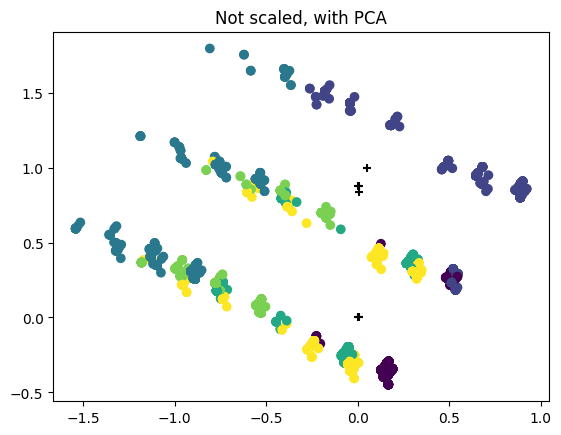

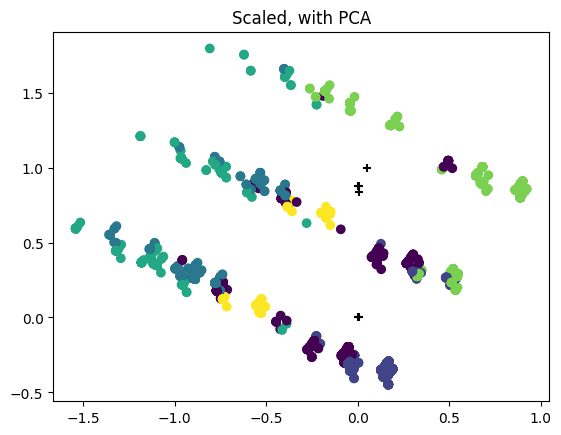

In [136]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(kmean_data)
kmean_pred = kmeans.predict(kmean_data)

kmeans_with_scaled = KMeans(n_clusters=6)
kmeans_with_scaled.fit(kmean_data_scaled)
kmean_pred_from_scaled = kmeans_with_scaled.predict(kmean_data_scaled)

pca = PCA(n_components=2)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

X_pca = pca.fit_transform(kmean_data)
ax1.scatter(X_pca[:,0], X_pca[:,1], c=kmean_pred)
ax1.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', marker='+')
ax1.set_title("Not scaled, with PCA")
fig1.savefig("./static/kmeansplot2_noscale_pca.png")

X_pca = pca.fit_transform(kmean_data_scaled)
ax2.scatter(X_pca[:,0], X_pca[:,1], c=kmean_pred_from_scaled)
ax2.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', marker='+')
ax2.set_title("Scaled, with PCA")
fig2.savefig("./static/kmeansplot4_scale_pca.png")



Visualize + knee point

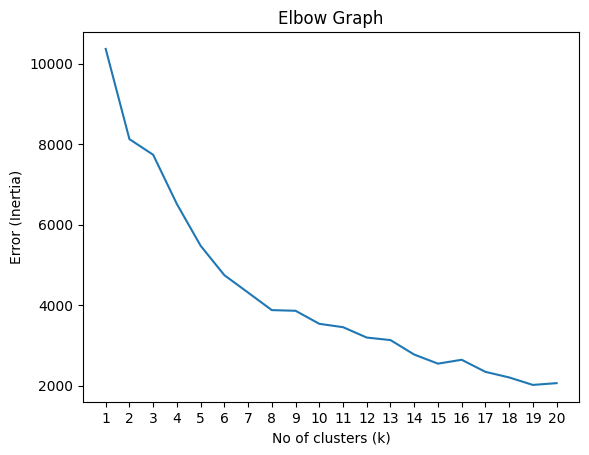

In [118]:
error = []
for i in range(1,21):
 kmeans = KMeans(n_clusters=i).fit(kmean_data_scaled)
 error.append(kmeans.inertia_)

plt.plot(range(1,21), error)
plt.title("Elbow Graph")
plt.xlabel("No of clusters (k)")
plt.ylabel("Error (Inertia)")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.savefig("static/kmeans_elbowgraph.png")

### Clustering for images

In [26]:
def image_kmeans(path: str, clusters: int = 5):
    source_image = cv2.imread(path)
    image = cv2.cvtColor(source_image, cv2.COLOR_RGB2BGR)
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    K=clusters
    _, labels, (centers) = cv2.kmeans(pixel_values, K, None, criteria, 10,
    cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    labels = labels.flatten()

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    plt.figure(figsize=(10,10))
    fig, axs = plt.subplots(1,2)

    axs[0].imshow(image)
    axs[0].set_title("oprindelige billede")
    axs[1].imshow(segmented_image)
    axs[1].set_title("K-means clustering på billede")
    plt.savefig("static/clustered_image.png")

# image_kmeans(r"Data\train\0a51fa22c7b84249889d1e157c54c11f.jpg")
# image_kmeans(r"Data\train\0adbd3eeacf2e8318dc0313a5738543f.jpg")

## Uge 16+17 kapitel 12+13

In [120]:
# Laver Dataframen om til numpy arrays og specificerer dem som datatypen "np.float32"
logiX_train_as_array = np.array(logiX_train, dtype=np.float32)
logiX_test_as_array = np.array(logiX_test, dtype=np.float32)
logiy_train_as_array = np.array(logiy_train, dtype=np.float32)
logiy_test_as_array = np.array(logiy_test, dtype=np.float32)

In [25]:
# Laver de konverterede numpy arrays om til Pytorch Tensors via torch.tensor
X_train_tensor = torch.tensor(logiX_train_as_array)
y_train_tensor = torch.tensor(logiy_train_as_array)
X_test_tensor = torch.tensor(logiX_test_as_array)
y_test_tensor = torch.tensor(logiy_test_as_array)

In [6]:
# Definerer det neutrale netværks model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(X_train_tensor.shape[1], 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

In [122]:
# Træner det neutrale netværk
def train_nn_model(model, X_train, y_train, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
    return model

model = NeuralNetwork()
criterion = nn.MSELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # Stochastic Gradient Descent

nn_model = train_nn_model(model, X_train_tensor, y_train_tensor, criterion, optimizer)
torch.save(nn_model, "models/neural_network_for_human.pt")


Epoch 1/50, Loss: 0.2771
Epoch 2/50, Loss: 0.2770
Epoch 3/50, Loss: 0.2770
Epoch 4/50, Loss: 0.2769
Epoch 5/50, Loss: 0.2768
Epoch 6/50, Loss: 0.2768
Epoch 7/50, Loss: 0.2767
Epoch 8/50, Loss: 0.2766
Epoch 9/50, Loss: 0.2766
Epoch 10/50, Loss: 0.2765
Epoch 11/50, Loss: 0.2764
Epoch 12/50, Loss: 0.2763
Epoch 13/50, Loss: 0.2763
Epoch 14/50, Loss: 0.2762
Epoch 15/50, Loss: 0.2761
Epoch 16/50, Loss: 0.2761
Epoch 17/50, Loss: 0.2760
Epoch 18/50, Loss: 0.2759
Epoch 19/50, Loss: 0.2759
Epoch 20/50, Loss: 0.2758
Epoch 21/50, Loss: 0.2757
Epoch 22/50, Loss: 0.2757
Epoch 23/50, Loss: 0.2756
Epoch 24/50, Loss: 0.2755
Epoch 25/50, Loss: 0.2755
Epoch 26/50, Loss: 0.2754
Epoch 27/50, Loss: 0.2753
Epoch 28/50, Loss: 0.2753
Epoch 29/50, Loss: 0.2752
Epoch 30/50, Loss: 0.2751
Epoch 31/50, Loss: 0.2751
Epoch 32/50, Loss: 0.2750
Epoch 33/50, Loss: 0.2749
Epoch 34/50, Loss: 0.2748
Epoch 35/50, Loss: 0.2748
Epoch 36/50, Loss: 0.2747
Epoch 37/50, Loss: 0.2746
Epoch 38/50, Loss: 0.2746
Epoch 39/50, Loss: 0.

In [123]:
# Evaluer modellen
def evaluate_nn_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        predicted = (y_pred > 0.5).float()
        accuracy = (predicted == y_test).float().mean().item()
        print(f'Test Accuracy: {accuracy:.2f}')
    return accuracy

nn_test_accuracy = evaluate_nn_model(nn_model, X_test_tensor, y_test_tensor)

Test Accuracy: 0.17


## Uge 18 kapitel 14

Data prep

In [29]:

class ImageDatasetFromCSV(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

csv_file = r"Data/cat_or_dog_train.csv"  # Replace with your CSV file path
image_dir = r"Data/cat_or_dog_train"  # Replace with your image directory

full_dataset = ImageDatasetFromCSV(csv_file, image_dir, transform=transform)

# Define the train-test split ratio
train_ratio = 0.8
test_ratio = 0.2
total_size = len(full_dataset)
train_size = int(total_size * train_ratio)
test_size = total_size - train_size

convolutional_train_data, convolutional_test_data = random_split(full_dataset, [train_size, test_size])

# Create DataLoader for train and test datasets
batch_size = 32
convolutional_train_loader = DataLoader(convolutional_train_data, batch_size=batch_size, shuffle=True)
convolutional_test_loader = DataLoader(convolutional_test_data, batch_size=batch_size, shuffle=False)



Convolutional neural network model

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        self.fully_connected_layer_1 = nn.Linear(in_features=32*7*7, out_features=64)
        self.drop = nn.Dropout(0.25)
        self.fully_connected_layer_2 = nn.Linear(in_features=64, out_features=64)
        self.fully_connected_layer_3 = nn.Linear(in_features=64, out_features=10)
    
    def forward(self, x):
        out = self.convlayer(x)
        out = out.view(out.size(0), -1)
        out = self.fully_connected_layer_1(out)
        out = self.drop(out)
        out = self.fully_connected_layer_2(out)
        out = self.fully_connected_layer_3(out)
        return out

CNN_model = CNN()

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.005)
lstlosses = []
lstiterations = []
lstaccuracy = []

predictions_list = []
labels_list = []

num_epochs = 3 
num_batches = 0 
batch_size = 16 

for epoch in range(num_epochs):
    print("Epoch: {} of {}".format(epoch + 1, num_epochs))
    for images, labels in convolutional_train_loader:
        train = Variable(images)
        labels = Variable(labels)

        outputs = CNN_model(train)
        loss = error(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_batches += 1

        if num_batches % batch_size == 0:
            total = 0
            matches = 0
            
            for images, labels in convolutional_test_loader:
                labels_list.append(labels)
                test = Variable(images)
                outputs = CNN_model(test)

                predictions = torch.max(outputs, 1)[1]
                predictions_list.append(predictions)
                matches += (predictions == labels).sum()
                total += len(labels)

            accuracy = matches * 100 / total
            lstlosses.append(loss.data)
            lstiterations.append(num_batches)
            lstaccuracy.append(accuracy)

        if not (num_batches % batch_size):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(num_batches, loss.data, accuracy))

print("Training completed.")
torch.save(CNN_model, "models/convolutional_neural_network.pt")



Epoch: 1 of 3
Iteration: 16, Loss: 0.8312647938728333, Accuracy: 50.0%
Iteration: 32, Loss: 0.6885508894920349, Accuracy: 50.125%
Iteration: 48, Loss: 0.6775642037391663, Accuracy: 50.125%
Iteration: 64, Loss: 0.6609006524085999, Accuracy: 53.75%
Iteration: 80, Loss: 0.6963109374046326, Accuracy: 57.875%
Iteration: 96, Loss: 0.6557121872901917, Accuracy: 58.875%
Iteration: 112, Loss: 0.6473006010055542, Accuracy: 56.625%
Iteration: 128, Loss: 0.6739694476127625, Accuracy: 61.625%
Iteration: 144, Loss: 0.644503116607666, Accuracy: 63.5%
Iteration: 160, Loss: 0.6601864695549011, Accuracy: 58.75%
Iteration: 176, Loss: 0.6163245439529419, Accuracy: 62.5625%
Iteration: 192, Loss: 0.6187691688537598, Accuracy: 59.5%
Epoch: 2 of 3
Iteration: 208, Loss: 0.6886438131332397, Accuracy: 56.1875%
Iteration: 224, Loss: 0.5838664770126343, Accuracy: 61.625%
Iteration: 240, Loss: 0.6203151345252991, Accuracy: 58.0625%
Iteration: 256, Loss: 0.6929939985275269, Accuracy: 62.5625%
Iteration: 272, Loss: 0

Applikation

In [31]:
def load_image(image_path):
    image = Image.open(image_path)
    return transform(image).unsqueeze(0)  # Add batch dimension

def predict_cat_or_dog_image(CNN_model, image_tensor):
    CNN_model.eval()
    with torch.no_grad(): 
        outputs = CNN_model(image_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted

def display_prediction(image_name, predicted_label):
    class_names = ['Cat', 'Dog']  
    prediction_text = f"Predicted label: {predicted_label.item()} ({class_names[predicted_label]})"

    return prediction_text

def on_predict():
    image_name = entry.get()
    if not image_name:
        messagebox.showwarning("Input Error", "Please enter an image name.")
        return

    try:
        image_name_path = "Data/train/" + image_name + ".jpg"

        image_tensor = load_image(image_name_path)

        predicted_label = predict_cat_or_dog_image(CNN_model, image_tensor)

        prediction = display_prediction(image_name_path, predicted_label)

        result_label.config(text=prediction)

    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

window = tk.Tk()
window.title("Image Prediction Application")
window.geometry("600x400")

tk.Label(window, text="Enter image name:").pack(pady=10)
entry = tk.Entry(window, width=50)
entry.pack(pady=10)

predict_button = tk.Button(window, text="Predict", command=on_predict)
predict_button.pack(pady=10)

result_label = tk.Label(window, text="", fg="blue")
result_label.pack(pady=20)

window.mainloop()

Uge 15 del 2

Data prep

In [32]:
csv_file = r"Data/train.csv"
image_dir = r"Data/train"

df = pd.read_csv(csv_file, nrows=100)

label_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

labels_df = df[['Id'] + label_columns]


Classes og funktioner

In [33]:
class ImageDatasetFromCSV(Dataset):
    def __init__(self, labels_df, image_dir, transform=None, file_extension='.jpg'):
        self.labels_df = labels_df
        self.image_dir = image_dir
        self.transform = transform
        self.file_extension = file_extension


    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels_df.iloc[idx, 0] + self.file_extension)
        image = Image.open(img_name)
        labels = torch.tensor(self.labels_df.iloc[idx, 1:].values.astype('float32'))

        if self.transform:
            image = self.transform(image)

        return image, labels

class MultiLabelCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelCNN, self).__init__()
        self.multi_model = models.resnet18(pretrained=True)
        self.multi_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.multi_model.fc = nn.Linear(self.multi_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.multi_model(x)

num_classes = len(label_columns)
multi_model = MultiLabelCNN(num_classes)

full_dataset = ImageDatasetFromCSV(labels_df, image_dir, transform=transform)

c:\Users\blabl\Desktop\PAW\PetfinderPawpularityScore\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\blabl\Desktop\PAW\PetfinderPawpularityScore\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training

In [34]:
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = torch.optim.Adam(multi_model.parameters(), lr=0.001)

batch_size = 16
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lstlosses = []
lstiterations = []
lstaccuracy = []

num_epochs = 2 
num_batches = 0 
print_interval = 5

def train_nn_model(multi_model, train_loader, criterion, optimizer, num_epochs, num_batches):
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1} of {num_epochs}")  
        for images, labels in train_loader:
            images = Variable(images)
            labels = Variable(labels)

            outputs = multi_model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num_batches += 1

            if num_batches % print_interval == 0:
                total = 0
                correct = 0
                
                with torch.no_grad():
                    for images, labels in test_loader:
                        images = Variable(images)
                        labels = Variable(labels)
                        outputs = multi_model(images)
                        predicted = (outputs > 0.5).float()
                        correct += (predicted == labels).sum().item()
                        total += labels.numel() 

                accuracy = 100 * correct / total
                lstlosses.append(loss.item())
                lstiterations.append(num_batches)
                lstaccuracy.append(accuracy)

                print(f"Iteration: {num_batches}, Loss: {loss.item()}, Accuracy: {accuracy}%")

def evaluate_model(multi_model, test_loader):
    multi_model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = Variable(images)
            labels = Variable(labels)
            outputs = multi_model(images)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.numel() 

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')

train_nn_model(multi_model, train_loader, criterion, optimizer, num_epochs, num_batches)

evaluate_model(multi_model, test_loader)

Epoch: 1 of 2
Iteration: 5, Loss: 0.47771522402763367, Accuracy: 87.08333333333333%
Epoch: 2 of 2
Iteration: 10, Loss: 0.33935222029685974, Accuracy: 87.5%
Test Accuracy: 79.58333333333333%


Application

In [35]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

def predict_all_labels_image(multi_model, image_tensor):
    multi_model.eval() 
    with torch.no_grad(): 
        outputs = multi_model(image_tensor)
        predictions = torch.sigmoid(outputs).squeeze().numpy()
        predicted_labels = [label_columns[i] for i in range(len(label_columns)) if predictions[i] > 0.5]
        print(predicted_labels)
    return predicted_labels

def display_prediction(predicted_labels):
    if not predicted_labels:
        return "No labels detected"
    else:
        return "Predicted labels: " + ", ".join(predicted_labels)

def on_predict():
    image_name = entry.get()
    if not image_name:
        messagebox.showwarning("Input Error", "Please enter an image name.")
        return

    try:
        image_name_path = os.path.join(r"Data/train", image_name + ".jpg")
        if not os.path.exists(image_name_path):
            raise FileNotFoundError(f"Image '{image_name}.jpg' not found in 'Data/train'")

        image_tensor = load_image(image_name_path)

        predicted_labels = predict_all_labels_image(multi_model, image_tensor)

        prediction = display_prediction(predicted_labels)

        result_label.config(text=prediction)

    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

window = tk.Tk()
window.title("Image Prediction Application")
window.geometry("600x400")

tk.Label(window, text="Enter image name:").pack(pady=10)
entry = tk.Entry(window, width=50)
entry.pack(pady=10)

predict_button = tk.Button(window, text="Predict", command=on_predict)
predict_button.pack(pady=10)

result_label = tk.Label(window, text="", fg="blue")
result_label.pack(pady=20)

window.mainloop()

In [42]:
class ModelHolder():
    scores = {}
    confusion_matrices = {}
    def __init__(self):
        self.lin_reg = torch.load("models/linear_regression.pt")
        self.log_reg_for_human = torch.load("models/logistic_regression.pt")
        self.gaussian_bayes_model = torch.load("models/gaussian_naive_bayes.pt")
        self.multinomial_bayes_model = torch.load("models/multinomial_naive_bayes.pt")
        self.rfc_bagging_model = torch.load("models/randomForestClassifier_with_bagging.pt")
        self.decisionTree_boosting_model = torch.load("models/decisionTreeClassifier_with_boosting.pt")
        self.stacking_model = torch.load("models/stackingClassifier.pt")
        self.nn_model = torch.load("models/neural_network_for_human.pt")
    cnn_model = CNN_model
    all_labels_model = multi_model

# TTK

In [31]:
class Application(tk.Tk):
    current_image_path = 'Not set yet'
    def __init__(self):
        super().__init__()

        self.window_width = "700"
        self.window_height = "700"
        self.geometry(self.window_width+"x"+self.window_height)

        self.model_holder = ModelHolder()

        self.checkbutton_frame = tk.Frame(self)

        self.labels = ["Subject Focus", "Eyes", "Face", "Near", "Action", "Accessory", "Group", "Collage", "Human", "Occlusion", "Info", "Blur"]
        self.check_vars = {}
        self.num_columns = 6
        for i, label in enumerate(self.labels):
            var = tk.BooleanVar()
            self.check_vars[label] = var

            checkbutton = tk.Checkbutton(self.checkbutton_frame, text=label, variable=var)

            row = i // self.num_columns
            column = i % self.num_columns

            checkbutton.grid(row=row, column=column, sticky="w", padx=5, pady=5)

        self.button_frame = tk.Frame(self)
        self.search_button = tk.Button(self.button_frame, text='Find billede', command=self.searchImage)

        self.result_frame = tk.Frame(self, height=400)
        self.score_Text = tk.Label(self.result_frame)

        self.image_frame = tk.Frame(self.result_frame, width=350)
        self.image_label = tk.Label(self.image_frame)
        self.image_kmeans_button = tk.Button(self.image_frame, text="Vis kmeans for bileldet", command=self.show_image_kmeans)

        self.metrics_frame = tk.Frame(self.result_frame)
        self.header_font = font.Font(weight="bold", size=14)
        self.metrics_header_label = tk.Label(self.metrics_frame, text="Metrics", font=self.header_font)
        self.performance_measure_label = tk.Label(self.metrics_frame, text="Performance measure")
        self.cross_validation_label = tk.Label(self.metrics_frame, text="Cross validation")
        self.nn_evaluation_label = tk.Label(self.metrics_frame, text="NN evaluation")
        self.roc_curve_button = tk.Button(self.metrics_frame, text="Vis Roc Curve", command=self.show_roccurve)

        self.image_properties_label = tk.Label(self.result_frame)
        self.occlussion_label = tk.Label(self.result_frame)
        self.cat_or_dog_label = tk.Label(self.result_frame)

        self.all_labels_cnn_label = Label(self.result_frame)
        self.all_labels_cnn_label.pack()

        self.options_frame = tk.Frame(self)

        self.pawpularity_options_frame = tk.Frame(self.options_frame)
        self.pawpularity_options_header = tk.Label(self.pawpularity_options_frame, text="Vælg model til at forudsige score", wraplength=200, font=self.header_font)
        self.choose_lin_reg_button = tk.Button(self.pawpularity_options_frame, text="Vælg lineær regression", command=self.use_lin_reg_for_pawpularity)
        
        self.human_options_frame = tk.Frame(self.options_frame)
        self.human_options_header = tk.Label(self.human_options_frame, text="Vælg model til at forudsige om der er menneske på billedet", wraplength=200, font=self.header_font)

        self.choose_log_reg_for_human_button = tk.Button(self.human_options_frame, text="Vælg logistisk regression", command=self.use_log_reg_for_human)
        self.choose_nn_for_human_button = tk.Button(self.human_options_frame, text="Vælg Neural network", command=self.use_nn_for_human)
        self.choose_ens_methods_for_human_button = tk.Button(self.human_options_frame, text="Vælg ensemble metoder", command=self.use_ens_methods_for_human)

        self.occlusion_options_frame = tk.Frame(self.options_frame)
        self.occlusion_options_header = tk.Label(self.occlusion_options_frame, text="Vælg model til at forudsige om der er occlusion på billedet", wraplength=200, font=self.header_font)
        self.choose_bayes_for_occlusion_button = tk.Button(self.occlusion_options_frame, text="Vælg Bayes", command=self.use_bayes_for_occlusion)
        self.choose_ensemble_methods_for_occlusion_button = tk.Button(self.occlusion_options_frame, text="Vælg Ensemble metoder", command=self.use_ens_methods_for_occlusion)

        # Packing
        self.checkbutton_frame.pack(padx=10, pady=10)

        self.button_frame.pack(padx=10, pady=10)
        self.search_button.pack()

        self.result_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        self.score_Text.pack()

        self.image_frame.pack(padx=10, pady=10, side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.image_label.pack()

        self.metrics_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        self.metrics_header_label.pack()
        self.performance_measure_label.pack(anchor="w")
        self.cross_validation_label.pack(anchor="w")
        self.roc_curve_button.pack()

        self.image_properties_label.pack()
        self.occlussion_label.pack()
        self.cat_or_dog_label.pack()

        self.options_frame.pack(padx=10, pady=10)

        self.pawpularity_options_frame.pack(padx=10, pady=10, side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.pawpularity_options_header.pack()
        self.choose_lin_reg_button.pack()

        self.human_options_frame.pack(padx=10, pady=10, side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.human_options_header.pack()
        self.choose_log_reg_for_human_button.pack()
        self.choose_nn_for_human_button.pack()
        self.choose_ens_methods_for_human_button.pack()

        self.occlusion_options_frame.pack(padx=10, pady=10, side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.occlusion_options_header.pack()
        self.choose_bayes_for_occlusion_button.pack()
        self.choose_ensemble_methods_for_occlusion_button.pack()

        self.image_search_result = pd.DataFrame()
        self.displayed_image_row = pd.Series()
    
    def searchImage(self):
        self.image_search_result = train_data.loc[(train_data["Subject Focus"] == self.check_vars["Subject Focus"].get()) & (train_data["Eyes"] ==self.check_vars["Eyes"].get()) & (train_data["Face"] == self.check_vars["Face"].get()) & (train_data["Near"] == self.check_vars["Near"].get()) & (train_data["Action"] == self.check_vars["Action"].get()) & (train_data["Accessory"] == self.check_vars["Accessory"].get()) & (train_data["Group"] == self.check_vars["Group"].get()) & (train_data["Collage"] == self.check_vars["Collage"].get()) & (train_data["Human"] == self.check_vars["Human"].get()) & (train_data["Occlusion"] == self.check_vars["Occlusion"].get()) & (train_data["Info"] == self.check_vars["Info"].get()) & (train_data["Blur"] == self.check_vars["Blur"].get())]
        self.use_log_reg_for_human()
        if not (self.displayed_image_row.isnull().all()):
            name = self.displayed_image_row.name
            img_url = f"Data\\train\\{str(name)}.jpg"
            self.display_image(img_url)
            self.use_lin_reg_for_pawpularity()
            self.update_cross_validation_label()
            self.image_kmeans_button.pack()
        else:
            self.image_label.config(text="Der var ikke nogle billeder med de valgte værdier")

    def detect_human_with_logistic_regression(self, reg, data_row):
        columns = ["Occlusion", "Near", "Subject Focus", "Group"]
        return reg.predict(pd.DataFrame([data_row], columns=columns))

    def detect_human_with_nn(self, tensor):
        nn_model.eval()
        with torch.no_grad():
            y_pred = nn_model(tensor)
        return y_pred.item()

    def score_image_with_linear_regression(self, reg, data_row: pd.Series):
        data_row = data_row.drop(["Pawpularity"])
        return reg.predict(data_row.to_frame().transpose())

    def display_image(self, path: str):
        img = Image.open(path)
        height = 250
        img = self.resize_image(img,height = height)
        tk_img = ImageTk.PhotoImage(img)
        self.image_label.configure(image=tk_img)
        self.image_label.image = tk_img
        self.update_cat_or_dog_label(path)
        self.update_all_labels_cnn_label(path)

    def show_image_window(self, path: str):
        img = Image.open(path)
        image = ImageTk.PhotoImage(img)
        window = tk.Toplevel(self)
        window.title("Image Viewer")
        
        label = tk.Label(window, image=image)
        label.image = image
        label.pack()
    
    def show_image_kmeans(self):
        path = "Data/train/" + self.displayed_image_row.name + ".jpg"
        image_kmeans(path)
        self.show_image_window("static/clustered_image.png")

    def show_roccurve(self):
        path = "static\\roccurve_logisticregression.png"
        self.show_image_window(path)

    def resize_image(self, img: pil.Image.Image, height: int = 200, width: int = None):
        if (width == None):
            ratio = img.width/img.height
            width = int(ratio*height)
            return img.resize((width,height), Image.LANCZOS)
        else:
            ratio = img.height/img.width
            height = int(ratio*width)
            return img.resize((width,height), Image.LANCZOS)
    
    def update_image_label(self):
        img_url = f"Data\\train\\{str(self.displayed_image_row.name)}.jpg"
        self.display_image(img_url)

    def update_performance_measure_label(self):
        measure = get_performancemetrics(self.model_holder.log_reg_for_human,logiX_test,logiy_test,"logisticregression")
        self.performance_measure_label.config(text="Performance measures:\n" + measure)

    def update_cross_validation_label(self):
        scores = do_crossvalidation()
        self.cross_validation_label.config(text="Cross validation scores:\n" + scores)

    def update_nn_evaluation_label(self):
        evaluation = nn_test_accuracy
        self.nn_evaluation_label.config(text="Neural network evaluation score:\n" + str(evaluation))

    def update_cat_or_dog_label(self, path):
        result = self.use_cnn_for_cat_or_dog(path)
        if(result == 0):
            cat_or_dog = "Kat"
        else:
            cat_or_dog = "Hund"
        self.cat_or_dog_label.config(text="Image is a " + cat_or_dog)
    
    def update_all_labels_cnn_label(self, path):
        result = self.use_cnn_for_all_labels(path)

        labels_string = "Image contains: "

        for label in result:
            labels_string += label + " "

        self.all_labels_cnn_label.config(text=labels_string)
    
    def update_image_properties_label(self):
        properties = ""
        self.image_properties_label.config(text="Poperties: " + properties)
    
    def update_occlusion_label(self, content):
        self.image_properties_label.config(text="Er der occlusion? " + content)

    def use_lin_reg_for_pawpularity(self):
        score = self.score_image_with_linear_regression(self.model_holder.lin_reg, self.displayed_image_row)
        actual_score = self.displayed_image_row["Pawpularity"]
        self.score_Text.config(text="predicted score = " + str(score[0]) + ". Actual score = " + str(actual_score))

    def use_log_reg_for_human(self):
        if len(self.image_search_result) > 0:
            for idx, row in self.image_search_result.iterrows():
                if self.detect_human_with_logistic_regression(self.model_holder.log_reg_for_human, row) == 0:
                    self.displayed_image_row = row
                    self.update_image_label()
                    break
            self.update_performance_measure_label()
    
    def use_nn_for_human(self):
        if len(self.image_search_result) > 0:
            columns = ["Occlusion", "Near", "Subject Focus", "Group"]
            for idx, row in self.image_search_result.iterrows():
                row = row[columns].values.astype(float)
                tensor = torch.tensor(row, dtype=torch.float32)
                self.model_holder.nn_model.eval()
                with torch.no_grad():
                    y_pred = nn_model(tensor)
                # human = trained_nn_model(tensor)
                if y_pred.item() < 0.5:
                    self.displayed_image_row = row
                    self.update_image_label()
                    break
            self.update_nn_evaluation_label()
    
    def use_bayes_for_occlusion(self):
        columns = ["Pawpularity", "Occlusion"]
        row = self.displayed_image_row.drop(columns)
        g_result = self.model_holder.gaussian_bayes_model.predict(row.to_frame().transpose())
        m_result = self.model_holder.multinomial_bayes_model.predict(row.to_frame().transpose())
        gauss = "Ja" if g_result == 1 else "Nej"
        multinomial = "Ja" if m_result == 1 else "Nej"
        occlusion = "\nGaussian: " + gauss + "\nMultinomial: " + multinomial
        self.update_occlusion_label(occlusion)
    
    def use_ens_methods_for_occlusion(self):
        columns = ["Pawpularity", "Occlusion"]
        row = self.displayed_image_row.drop(columns)
        df = row.to_frame().transpose()
        bag_res = self.model_holder.rfc_bagging_model.predict(df)
        boos_res = self.model_holder.decisionTree_boosting_model.predict(df)
        stack_res = self.model_holder.stacking_model.predict(df)
        bagging = "Ja" if bag_res == 1 else "Nej"
        boosting = "Ja" if boos_res == 1 else "Nej"
        stacking = "Ja" if stack_res == 1 else "Nej"
        occlusion = "\nBagging: " + bagging + "\nBoosting: " + boosting + "\nStacking: " + stacking
        self.update_occlusion_label(occlusion)

    
    def use_ens_methods_for_human(self):
        pass

    def use_cnn_for_cat_or_dog (self, path):
        image = Image.open(path)
        tensor_image = transform(image).unsqueeze(0)  # Add batch dimension
        return predict_cat_or_dog_image(ModelHolder.cnn_model, tensor_image)
    
    def use_cnn_for_all_labels (self, path):
        image = Image.open(path).convert('RGB')
        tensor_image = transform(image).unsqueeze(0)  # Add batch dimension
        return predict_all_labels_image(ModelHolder.all_labels_model, tensor_image)

if __name__ == "__main__":
    app = Application()
    app.mainloop()

['Eyes', 'Face', 'Near']
['Eyes', 'Face', 'Near']
['Eyes', 'Face', 'Near']
['Near']
['Near']
['Near']
['Near']
['Eyes', 'Face', 'Near']
['Eyes', 'Face', 'Near']
['Eyes', 'Face', 'Near']
['Eyes', 'Face', 'Near']
['Eyes', 'Face', 'Near']
['Eyes', 'Face', 'Near']
['Near']
['Near']
